**Installation Requirements**

In [ ]:
!pip install datasets
!pip install transformers[sentencepiece]
!pip install torch
!pip install accelerate -U
!transformers-cli cache clear
!pip install transformers==4.46.3
!pip install accelerate==0.26.0
!pip install transformers[torch]

**Necessary Imports**

In [18]:
import torch
import faiss
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import DataCollatorForSeq2Seq, Trainer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from transformers import MT5ForConditionalGeneration, AutoTokenizer, RagTokenizer, RagSequenceForGeneration



**Dataset Loading**

In [2]:
ds = load_dataset("lavita/medical-qa-datasets", "all-processed")
df = pd.DataFrame(ds['train'])
df

,instruction,input,output,__index_level_0__
0,"If you are a doctor, please answer the medical...",hi. im a home health aide and i have a client ...,"hi, thanks for contacting chatbot. swelling in...",137213
1,Please summerize the given abstract to a title,RATIONALE: The COVID-19 pandemic struck an imm...,Hydroxychloroquine vs. Azithromycin for Hospit...,67540
2,Please summerize the given abstract to a title,Objectives: To investigate the experience of p...,Playing the harmonica with chronic obstructive...,109854
3,"If you are a doctor, please answer the medical...","Hi, Im sorry to bother you but I have fpund a ...",welcome to chatbot .1. the history suggest a p...,137309
4,"If you are a doctor, please answer the medical...","Hi, my penis has a slightly lighter spot at t...","hello, skin color changes, discoloration etc. ...",135382
...,...,...,...,...
239352,"If you are a doctor, please answer the medical...",Hi my three year old has a red earlobe at the ...,"dear sir/ madam, thank you for posting your qu...",130830
239353,Answer this question truthfully,What is the other name for the pituitary gland...,"The pituitary gland, also known as the hypophy...",16631
239354,"If you are a doctor, please answer the medical...","hi, i am looking for advice for my 9 year old ...","hello, possible causes like contusion followin...",215344
239355,Answer this question truthfully,What are the main preventive measures for reti...,"Retinitis pigmentosa is a genetic, inherited d...",36409


In [3]:
df.to_csv('Dataset.csv', index=False)

In [4]:
main_data = pd.read_csv('Dataset.csv')
main_data = main_data[:25000]   # Model will train on 25000 data
main_data = main_data.dropna()  # Drop data row with null values
print("Length of main data:",len(main_data))


Length of main data: 24958


**Data Splitting**

In [5]:
#Train, Test, Validation Split
train, test = train_test_split(main_data, test_size=0.2, random_state=42, shuffle= True)
train, val = train_test_split(train, test_size=0.1, random_state=42, shuffle= True)
print("Length of train data:",len(train))
print("Length of test data:",len(test))
print("Length of val data:",len(val))

Length of train data: 17969
Length of test data: 4992
Length of val data: 1997


In [6]:
train.head()

,instruction,input,output,__index_level_0__
20395,"If you are a doctor, please answer the medical...","Hi, I always get back pain whenever i stand mo...","hi, welcome to chatbot. after going through yo...",239131
638,Answer this question truthfully,Which stage of non-REM sleep is typically desc...,Stage N1 of non-REM sleep is typically describ...,18423
10833,Please summerize the given abstract to a title,The transport of oxygen between blood and tiss...,"Blood flow, capillary transit times, and tissu...",93373
7067,Answer this question truthfully,What is the anatomical landmark that correspon...,The nipple line corresponds to the level of T4...,22100
10316,Answer this question truthfully,What type of cells produce the cytokines that ...,The cytokines that mediate class switching of ...,30205


In [7]:
# Check for NaN values in train, validation and test
nan_count = train.isna().sum()
print(f"Columns with NaN values in Train split: {nan_count[nan_count > 0]}")

nan_count = val.isna().sum()
print(f"Columns with NaN values in Validation split: {nan_count[nan_count > 0]}")

nan_count = test.isna().sum()
print(f"Columns with NaN values in Test split: {nan_count[nan_count > 0]}")

Columns with NaN values in Train split: Series([], dtype: int64)
Columns with NaN values in Validation split: Series([], dtype: int64)
Columns with NaN values in Test split: Series([], dtype: int64)


Train data length visualization

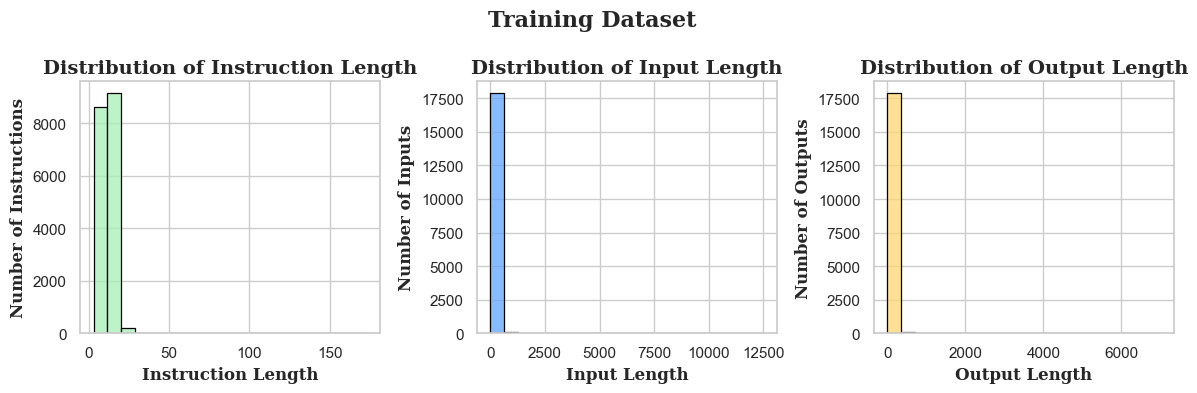

In [9]:
# Calculate the lengths of the columns
train['instruction_length'] = train['instruction'].apply(lambda x: len(str(x).split()))
train['input_length'] = train['input'].apply(lambda x: len(str(x).split()))
train['output_length'] = train['output'].apply(lambda x: len(str(x).split()))

# Set the aesthetic style and font settings
sns.set(style="whitegrid")
font_label = {'fontfamily': 'serif', 'fontsize': 12, 'fontweight': 'bold'}
font_title = {'fontfamily': 'serif', 'fontsize': 14, 'fontweight': 'bold'}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

# Plot 1: Distribution of Context Length
sns.histplot(data=train, x='instruction_length', bins=20,  edgecolor='black', color='#a7efb7', ax=axes[0])
axes[0].set_title('Distribution of Instruction Length', fontdict=font_title)
axes[0].set_xlabel('Instruction Length', fontdict=font_label)
axes[0].set_ylabel('Number of Instructions', fontdict=font_label)

# Plot 2: Distribution of Question Length
sns.histplot(data=train, x='input_length', bins=20,  edgecolor='black', color='#5ea6ff', ax=axes[1])
axes[1].set_title('Distribution of Input Length', fontdict=font_title)
axes[1].set_xlabel('Input Length', fontdict=font_label)
axes[1].set_ylabel('Number of Inputs', fontdict=font_label)

# Plot 3: Distribution of Answer Length
sns.histplot(data=train, x='output_length', bins=20,  edgecolor='black', color='#ffd772', ax=axes[2])
axes[2].set_title('Distribution of Output Length', fontdict=font_title)
axes[2].set_xlabel('Output Length', fontdict=font_label)
axes[2].set_ylabel('Number of Outputs', fontdict=font_label)

# Set a title for the set of subplots
plt.suptitle('Training Dataset', fontfamily='serif',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Train data unique word counts

In [10]:
# Tokenize 'instruction', 'input', and 'output' columns to count unique words
instruction_words = ' '.join([str(word) for word in train['instruction']]).split()
input_words = ' '.join([str(word) for word in train['input']]).split()
output_words = ' '.join([str(word) for word in train['output']]).split()

# Calculate unique words
unique_instruction_words = len(set(instruction_words))
unique_input_words = len(set(input_words))
unique_output_words = len(set(output_words))

# Display the count of unique words
print(f"Number of unique words in 'Instruction': {unique_instruction_words}")
print(f"Number of unique words in 'Input': {unique_input_words}")
print(f"Number of unique words in 'Output': {unique_output_words}")

Number of unique words in 'Instruction': 896
Number of unique words in 'Input': 139243
Number of unique words in 'Output': 67084


**mT5 Model and its Tokenizer Loading**

In [11]:
# https://huggingface.co/docs/transformers/model_doc/mt5
model_name = "google/mt5-small"
model = MT5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


**Custom Dataset Class**

In [12]:
class MedicalQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=520):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        instruction = self.data.iloc[idx]['instruction']
        input = self.data.iloc[idx]['input']
        output = self.data.iloc[idx]['output']

        # Tokenize instruction and input separately
        inputs = self.tokenizer(
            instruction,
            input,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize output
        tokenized_output = self.tokenizer(
            output,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Process tokenized output labels
        labels = tokenized_output['input_ids'].squeeze()
        attention_mask_labels = tokenized_output['attention_mask'].squeeze()

        # Ignore padded tokens during training
        labels[attention_mask_labels == 0] = -100

        # Handle cases where the input sequence is longer than max_length
        if inputs['input_ids'].shape[1] > self.max_length:
            inputs['input_ids'] = inputs['input_ids'][:, :self.max_length]
            inputs['attention_mask'] = inputs['attention_mask'][:, :self.max_length]
            attention_mask_labels = attention_mask_labels[:self.max_length]

        # Ensuring labels and attention_mask_labels have the same length
        labels = labels[:self.max_length]

        # Using .squeeze() on labels
        labels = labels.squeeze()

        # Return as dictionaries
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels,

        }


In [13]:
train_dataset = MedicalQADataset(train, tokenizer)
validation_dataset = MedicalQADataset(val, tokenizer)
test_dataset = MedicalQADataset(test, tokenizer)

train_dataloader = DataLoader(train_dataset , batch_size=10, shuffle=True)
validation_dataloader = DataLoader(validation_dataset , batch_size=10, shuffle=False)
test_dataloader = DataLoader(test_dataset , batch_size=10, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

**Training Arguments**

In [15]:
from transformers import TrainingArguments
from torch.optim import AdamW

# Create a custom optimizer using torch.optim.AdamW
custom_optimizer = AdamW(
    model.parameters(),
    lr=1e-3,
    eps=1e-8,  # Epsilon value to prevent division by zero
    weight_decay=0.01,  # Weight decay (L2 regularization)
)

# Define the TrainingArguments for question answering
training_args = TrainingArguments(
    output_dir='Medical_mT5_QA',
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    evaluation_strategy="steps",
    eval_steps=500,
    save_total_limit=2,
    save_steps=500,
    learning_rate=1e-3,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    lr_scheduler_type="cosine_with_restarts", 
    warmup_steps=100, 
    weight_decay=0.01,  
    logging_dir='Medical_mT5_QA',  
    logging_steps=500, 
)

c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Custom Data Collator for Question Answering
class CustomDataCollatorForSeq2Seq(DataCollatorForSeq2Seq):
    def __call__(self, features):
        batch = super().__call__(features)

        # Find the maximum length of labels in the batch
        max_label_length = max(feature["labels"].shape[-1] for feature in features)

        # Pad or truncate the "labels" arrays to have the same length
        batch["labels"] = torch.stack([
            F.pad(torch.as_tensor(feature["labels"]), (0, max_label_length - feature["labels"].shape[-1]), value=-100)
            for feature in features
        ])

        return batch

# Creating a data collator using the custom collator
data_collator = CustomDataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=520,
    label_pad_token_id=tokenizer.pad_token_id,
    pad_to_multiple_of=8  # Ensuring the sequence length is a multiple of 8 (adjust as needed)
)

**Trainer**

In [ ]:
# Define the Trainer with the custom optimizer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    optimizers=(custom_optimizer, None),  # Passing the custom optimizer here
)

# Fine-tune the model
trainer.train()

  0%|          | 0/6738 [00:00<?, ?it/s]

c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\data\data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'loss': 5.012, 'grad_norm': 21.42843246459961, 'learning_rate': 0.0009910671955235518, 'epoch': 0.22}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 3.318946599960327, 'eval_runtime': 183.9233, 'eval_samples_per_second': 10.858, 'eval_steps_per_second': 1.359, 'epoch': 0.22}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 3.297, 'grad_norm': 14.066604614257812, 'learning_rate': 0.0009553240154328744, 'epoch': 0.45}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 3.1201469898223877, 'eval_runtime': 182.8692, 'eval_samples_per_second': 10.92, 'eval_steps_per_second': 1.367, 'epoch': 0.45}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 3.0922, 'grad_norm': 14.117891311645508, 'learning_rate': 0.0008942027842599241, 'epoch': 0.67}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.9932949542999268, 'eval_runtime': 183.0811, 'eval_samples_per_second': 10.908, 'eval_steps_per_second': 1.366, 'epoch': 0.67}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.9709, 'grad_norm': 20.825345993041992, 'learning_rate': 0.0008111101699474051, 'epoch': 0.89}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.926253318786621, 'eval_runtime': 178.353, 'eval_samples_per_second': 11.197, 'eval_steps_per_second': 1.402, 'epoch': 0.89}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.8016, 'grad_norm': 10.232963562011719, 'learning_rate': 0.0007106774428415079, 'epoch': 1.11}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.851081371307373, 'eval_runtime': 179.3133, 'eval_samples_per_second': 11.137, 'eval_steps_per_second': 1.394, 'epoch': 1.11}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.6645, 'grad_norm': 14.661459922790527, 'learning_rate': 0.0005985023460711612, 'epoch': 1.34}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.8055081367492676, 'eval_runtime': 179.2347, 'eval_samples_per_second': 11.142, 'eval_steps_per_second': 1.395, 'epoch': 1.34}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.6076, 'grad_norm': 5.96925687789917, 'learning_rate': 0.00048083709836304505, 'epoch': 1.56}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.7519586086273193, 'eval_runtime': 183.1515, 'eval_samples_per_second': 10.904, 'eval_steps_per_second': 1.365, 'epoch': 1.56}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.5488, 'grad_norm': 10.79973030090332, 'learning_rate': 0.0003642399188440512, 'epoch': 1.78}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.7115800380706787, 'eval_runtime': 183.0441, 'eval_samples_per_second': 10.91, 'eval_steps_per_second': 1.366, 'epoch': 1.78}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.496, 'grad_norm': 8.96737289428711, 'learning_rate': 0.0002552094965303274, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.6861019134521484, 'eval_runtime': 183.9122, 'eval_samples_per_second': 10.858, 'eval_steps_per_second': 1.359, 'epoch': 2.0}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.3579, 'grad_norm': 18.813644409179688, 'learning_rate': 0.0001598227778011873, 'epoch': 2.23}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.6668498516082764, 'eval_runtime': 180.8901, 'eval_samples_per_second': 11.04, 'eval_steps_per_second': 1.382, 'epoch': 2.23}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.2945, 'grad_norm': 9.175491333007812, 'learning_rate': 8.339626022414304e-05, 'epoch': 2.45}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.654149293899536, 'eval_runtime': 177.5388, 'eval_samples_per_second': 11.248, 'eval_steps_per_second': 1.408, 'epoch': 2.45}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.315, 'grad_norm': 9.790327072143555, 'learning_rate': 3.018967094156022e-05, 'epoch': 2.67}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.6444311141967773, 'eval_runtime': 182.1515, 'eval_samples_per_second': 10.963, 'eval_steps_per_second': 1.372, 'epoch': 2.67}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'loss': 2.3145, 'grad_norm': 8.779308319091797, 'learning_rate': 3.168545473113238e-06, 'epoch': 2.89}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 2.6405537128448486, 'eval_runtime': 183.017, 'eval_samples_per_second': 10.912, 'eval_steps_per_second': 1.366, 'epoch': 2.89}


c:\Users\Jobair\miniconda3\envs\my3.8env\lib\site-packages\transformers\tokenization_utils_base.py:2852: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


{'train_runtime': 13333.4607, 'train_samples_per_second': 4.043, 'train_steps_per_second': 0.505, 'train_loss': 2.8103669218367378, 'epoch': 3.0}


TrainOutput(global_step=6738, training_loss=2.8103669218367378, metrics={'train_runtime': 13333.4607, 'train_samples_per_second': 4.043, 'train_steps_per_second': 0.505, 'total_flos': 2.89470627643392e+16, 'train_loss': 2.8103669218367378, 'epoch': 2.9998330458011018})

**Save Model**

In [ ]:
# Save the model
model.save_pretrained('Medical_QA_mT5_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('Medical_QA_mT5_Tokenizer.json')

**Loading Model**

In [19]:
# Load the saved model
model = MT5ForConditionalGeneration.from_pretrained('Medical_QA_mT5_Model_v2.pt')

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('Medical_QA_mT5_Tokenizer_v2.json')

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


**Evaluation Metrics**

In [ ]:
#Evaluation Metrics related necessary installation
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score
!pip install jiwer

   ---------------------------------------- 84.0/84.0 kB 784.8 kB/s eta 0:00:00


   ---------------------------------------- 1.7/1.7 MB 515.3 kB/s eta 0:00:00


**RAG Implementation in Answer Generation**

In [37]:
# Load Sentence Transformer for embeddings
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create FAISS index for context retrieval
def create_faiss_index(dataframe):
    contexts = dataframe['input'].to_list()
    embeddings = embed_model.encode(contexts)
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

index = create_faiss_index(main_data)

#save the index value for external use
faiss.write_index(index, "medical_qa_index.faiss") 

In [24]:
def retrieve_documents(query, k=5):
    query_embedding = embed_model.encode([query])
    distances, indices = index.search(query_embedding, k)
    
    # Get contexts based on indices retrieved
    retrieved_contexts = [main_data['input'][i] for i in indices[0]]
    return retrieved_contexts

In [26]:
def generate_answer(question):
    retrieved_contexts = retrieve_documents(question)
    
    # Combine retrieved contexts into one string for input to the model
    context_input = " ".join(retrieved_contexts)
    
    input_text = f"Context: {context_input}\nQuestion: {question}"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True)
    
    with torch.no_grad():
        outputs = model.generate(**inputs)
    
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

Manually Generate Answer of an Input

In [30]:
prompt = "What does colitis diversion mean?"
print(f"Response: {generate_answer(prompt)}")

Response: This is a very common cause of asthma attack


In [31]:
#Testing Model
decoded_predictions_batch = []
decoded_references_batch = []

# Loop through the test dataset and generate predictions
for batch in test_dataloader:
    inputs = batch['input_ids'].to('cuda')  # Move inputs to the 'cuda' device
    labels = batch['labels'].to('cuda')  # Move labels to the 'cuda' device

    # Ensuring the model, inputs, and labels are on the same device
    model = model.to(inputs.device)

    # Generating answers using our model
    with torch.no_grad():
        # Generating predictions
        predictions = model.generate(inputs, max_length=520, num_beams=4, early_stopping=True)

        # Decoding generated answers
        try:
            decoded_predictions_batch.extend(tokenizer.batch_decode(predictions.cpu(), skip_special_tokens=True))
        except Exception as e:
            print("Exception occurred during decoding (predictions):", e)


        # Decoding labels for references
        try:
            # Converting labels to a list of token IDs
            labels_list = labels.cpu()
             # Decoding each label sequence
            decoded_references_batch.extend([tokenizer.decode(ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True) for ids in labels_list])
        except Exception as e:
            print("Exception occurred during decoding (references):", e)


In [32]:
print(len(decoded_predictions_batch))
print(len(decoded_references_batch))

4992
4992


In [33]:
from evaluate import load

# Loading the evaluation metric for Character Error Rate (CER) and Word Error Rate (WER) and Exact Match(em)
cer_metric = load("cer")
wer_metric = load("wer")
exact_match_metric = load("exact_match")

# Loading BLEU and METEOR metrics
bleu_metric = load("bleu")
meteor = load('meteor')

# Calculating Character Error Rate (CER), Word Error Rate (WER) and Exact Match (EM)
results_CER = cer_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_WER = wer_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_em = exact_match_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)

# Calculating Bilingual Evaluation Understudy (BLEU) , Recall-Oriented Understudy for Gisting Evaluation (ROUGE) and METEOR(M)
results_bleu = bleu_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_met = meteor.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jobair\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jobair\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Jobair\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [34]:
print("Character Error Rate for QA:", results_CER)
print("Word Error Rate for QA:",results_WER)
print("Exact Match for QA:",results_em)
print("BLEU Score for QA:",results_bleu)
print("METEOR for QA:",results_met)

Character Error Rate for QA: 2.107802544933424
Word Error Rate for QA: 2.4611622473900745
Exact Match for QA: {'exact_match': 0.03786057692307692}
BLEU Score for QA: {'bleu': 0.014325751771329182, 'precisions': [0.06703331611688294, 0.01712138276599168, 0.007958605082827974, 0.004611085668322644], 'brevity_penalty': 1.0, 'length_ratio': 2.3919794676120167, 'translation_length': 875132, 'reference_length': 365861}
METEOR for QA: {'meteor': 0.18165625274272065}


In [35]:
from rouge_score import rouge_scorer


# Initialize the Rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

# Preprocess the text
def preprocess_text(text):
    tokens = text.split()
    return ' '.join(tokens)

# Calculate scores for each pair of predictions and references
rouge1_f1_scores = []
rouge1_precision_scores = []
rouge1_recall_scores = []
rouge2_f1_scores = []
rouge2_precision_scores = []
rouge2_recall_scores = []
rougeL_f1_scores = []
rougeL_precision_scores = []
rougeL_recall_scores = []

for ref, pred in zip(decoded_references_batch, decoded_predictions_batch):
    candidate_summary = preprocess_text(pred)
    reference_summary = preprocess_text(' '.join(ref))
    scores = scorer.score(reference_summary, candidate_summary)

    rouge1_f1_scores.append(scores['rouge1'].fmeasure)
    rouge1_precision_scores.append(scores['rouge1'].precision)
    rouge1_recall_scores.append(scores['rouge1'].recall)
    rouge2_f1_scores.append(scores['rouge2'].fmeasure)
    rouge2_precision_scores.append(scores['rouge2'].precision)
    rouge2_recall_scores.append(scores['rouge2'].recall)
    rougeL_f1_scores.append(scores['rougeL'].fmeasure)
    rougeL_precision_scores.append(scores['rougeL'].precision)
    rougeL_recall_scores.append(scores['rougeL'].recall)

# Calculate the average scores
avg_rouge1_f1 = sum(rouge1_f1_scores) / len(rouge1_f1_scores)
avg_rouge1_precision = sum(rouge1_precision_scores) / len(rouge1_precision_scores)
avg_rouge1_recall = sum(rouge1_recall_scores) / len(rouge1_recall_scores)
avg_rouge2_f1 = sum(rouge2_f1_scores) / len(rouge2_f1_scores)
avg_rouge2_precision = sum(rouge2_precision_scores) / len(rouge2_precision_scores)
avg_rouge2_recall = sum(rouge2_recall_scores) / len(rouge2_recall_scores)
avg_rougeL_f1 = sum(rougeL_f1_scores) / len(rougeL_f1_scores)
avg_rougeL_precision = sum(rougeL_precision_scores) / len(rougeL_precision_scores)
avg_rougeL_recall = sum(rougeL_recall_scores) / len(rougeL_recall_scores)

# Print the average scores
print("Average Rouge-1 F1 Score:", avg_rouge1_f1)
print("Average Rouge-1 Precision:", avg_rouge1_precision)
print("Average Rouge-1 Recall:", avg_rouge1_recall)

print("Average Rouge-2 F1 Score:", avg_rouge2_f1)
print("Average Rouge-2 Precision:", avg_rouge2_precision)
print("Average Rouge-2 Recall:", avg_rouge2_recall)

print("Average Rouge-L F1 Score:", avg_rougeL_f1)
print("Average Rouge-L Precision:", avg_rougeL_precision)
print("Average Rouge-L Recall:", avg_rougeL_recall)

Average Rouge-1 F1 Score: 0.048837907219695255
Average Rouge-1 Precision: 0.09081497447901307
Average Rouge-1 Recall: 0.04163022775091975
Average Rouge-2 F1 Score: 0.00014188425433658025
Average Rouge-2 Precision: 0.0003994167597108773
Average Rouge-2 Recall: 0.00011750379568266678
Average Rouge-L F1 Score: 0.04864620943870988
Average Rouge-L Precision: 0.09048871097077213
Average Rouge-L Recall: 0.041462639696329046


In [36]:
# Create a DataFrame to store answers
generated_output_df = pd.DataFrame({
    'Instruction': test['instruction'],  # Assuming 'test_data' contains our test dataset
    'Input': test['input'],  # Assuming 'test_data' contains our test dataset
    'Reference_Output': decoded_references_batch,
    'Generated_Output': decoded_predictions_batch
})

# Save generated answers to a CSV file
generated_output_df.to_csv("Medical_mT5_generated_answers.csv", index=False)

In [ ]:
# !zip -r datas.zip /content/datas

**UI Interface using Streamlit**

To run now command: streamlit run app.py
Note this code need to write on app.py file

Code to run on Cloab

In [ ]:
!pip install streamlit

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.125.199.78


In [ ]:
!streamlit run streamlit_code.py & npx localtunnel --port 8501

⠙⠹⠸⠼

⠴⠦⠧⠇⠏⠋⠙Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) 
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.199.78:8501

y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://kind-tigers-suffer.loca.lt
2024-12-03 05:41:33.373225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 05:41:33.395691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 05:41:33.402611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 05:41:34.675573: